# We want to detect lightcurves with single variations among lightcurves with multiple variations and no-variations
# We count the number of data points with deviations larger than n*sigma in multiple bins
# This is for finding single lens microlensing lightcurves among non-microlenisng lightcurves

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
from Common_functions import *
import random
import scipy.optimize as opt
%matplotlib inline

In [2]:
home = os.path.expanduser("~")

In [3]:

# Smoothing the data

def low_pass_filter(y, box_pts, mode='same', base=1):
    box = base*(np.ones(box_pts)/box_pts)
    y_filtered = np.convolve(y, box, mode=mode)
    if mode=='same':
        y_filtered[0:int(box_pts/2)]=y_filtered[int(box_pts/2)]
        y_filtered[len(y_filtered)-int(box_pts/2):len(y_filtered)]=y_filtered[len(y_filtered)-int(box_pts/2)]
    return y_filtered

In [5]:
# Reading in one single lightcurve
name = 'ulwdc1_002_W149.txt'
f = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/lc/'+str(name)
t,m,e = np.loadtxt(f,unpack=True)

F = 100**((np.max(m)-m)/5)

df = pd.DataFrame({'t': t, 'Flux_Ratio': F, 'magnitude': m, 'm_err': e})



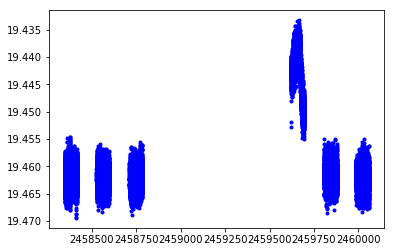

In [11]:
# Plotting one single light curve

plt.figure(1)
plt.plot(df['t'],low_pass_filter(df['magnitude'],8),'b.')
#plt.plot(df['t'][df['t']<2458500],df['magnitude'][df['t']<2458500],'b.')
plt.gca().invert_yaxis()
# plt.xlim(10000,12000)

In [7]:
#Determining the bins with sizes 30 days

bins = np.linspace(df.t.min(),df.t.max(),int((df.t.max()-df.t.min())/100))

In [8]:
#Dividing the time baseline of the lightcurve into the bins determined above

groups = df.groupby(np.digitize(df.t, bins))

In [9]:
# Calculating an array equal to (m - mean)/std(m) called del_m

std_ = np.std(df['magnitude'])
delta_m = []
t_ = []
c=0
for i in groups.indices:
    
    c = c+1
    
    m = df['magnitude'][groups.indices[i]]
    t = df['t'][groups.indices[i]]
    
    del_m = np.asarray((np.abs(m- m.mean())/std_))
    delta_m.append(del_m)
    t_.append(np.asarray(t))
    

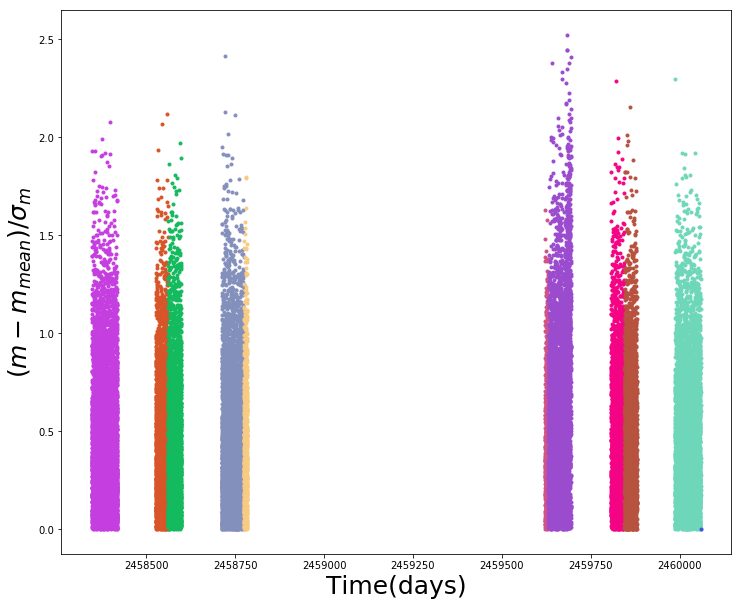

In [10]:
# Plotting del_m in different colors for each bin
# "#{:06x}".format(random.randint(0, 0xFFFFFF)) generates random colors

random.seed(0)

plt.figure(2)
plt.xlabel('Time(days)' ,size=25)
plt.ylabel('$(m-m_{mean})/{\sigma}_m$',size=25)
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
for i in range(len(delta_m)):

    plt.plot(t_[i],delta_m[i],'.',color="#{:06x}".format(random.randint(0, 0xFFFFFF)))
# plt.xlim(1600+2.458e6, 1650+2.458e6)

In [49]:
# Calculating number of data points with deviations larger than 3 sigma in each bin

n_outliers = []
for j in range(len(delta_m)):
    
    n_outliers.append(len(np.where(delta_m[j]>3)[0]))

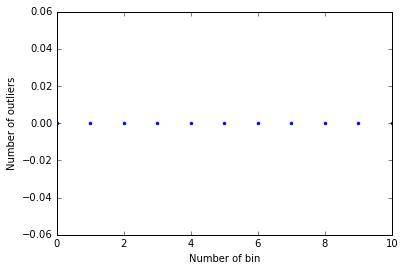

In [50]:
# Plotting number of outliers in each bin 

plt.figure(3)
plt.plot(n_outliers, 'b.')
plt.xlabel('Number of bin')
plt.ylabel('Number of outliers')

In [12]:
# # ASSUMPTION = t and m are panda dataframes
# # Create a function that: 
# # 1- Smoothes the lightcurve
# # 2- Divides it into bins of arbitrary sizes
# # 3- Calculates (m - mean)/std(m)
# # 4- Counts the number of outliers in each bin with deviations larger than threshold*sigma

# def count_peaks (t, m, smooth='yes', bin_size = 30, threshold = 3):
    
#     if smooth == 'yes':
#         m = low_pass_filter(m,8)
#     else:
#         pass
    
#     bins = np.linspace(t.min(),t.max(),int((t.max()-t.min())/bin_size))
#     groups = df.groupby(np.digitize(t, bins))
    
#     std_ = np.std(m)
#     delta_m = []
#     t__ = []
#     c=0
#     for i in groups.indices:
#         #print c
#         c = c+1
#         #print i
#         m_ = m[groups.indices[i]]
#         t_ = t[groups.indices[i]]
#         #print t,m
#         del_m = np.asarray((np.abs(m_- m_.mean())/std_))
#         delta_m.append(del_m)
#         t__.append(np.asarray(t_))
        
#     n_outliers = []
#     for j in range(len(delta_m)):
    
#         n_outliers.append(len(np.where(delta_m[j]>threshold)[0])) 
    
#     return n_outliers

In [13]:
# Testing the function on one single lightcurve

n_outliers = count_peaks(df['t'],df['magnitude'],bin_size=75,threshold = 4)

In [14]:
len(np.where(np.asarray(n_outliers)>0)[0])

2

ValueError: setting an array element with a sequence.

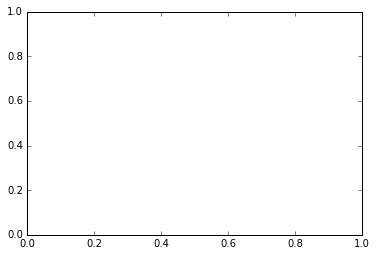

In [15]:
# Plotting the number of outliers in each bin

plt.figure(3)
plt.plot(n_outliers, 'b.')
plt.xlabel('Number of bin')
plt.ylabel('Number of outliers')

In [19]:
# Set up te directory where all microlensing data challenge lightcurves are

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/lc/'
direc = os.listdir(temp)

In [20]:
direc.sort()

In [21]:
# # Reading in all lightcurves one by one and calculate the number of outliers for each using the function count_peaks

# res = {'name':[], 'outliers':[], 'max_outliers':[], 'n_outliers':[]}

# for f in direc:
#     if f.endswith('.txt') and f.split('_')[2].startswith('W'):
        
#         t,m,e = np.loadtxt(temp+str(f),unpack=True)
        
#         df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': e})
#         #print np.std(m)
#         tempdata = count_peaks(df['t'],df['magnitude'],bin_size=30)
        
#         res['name'].append(f)
#         res['outliers'].append(tempdata)
#         res['max_outliers'].append(np.max(tempdata))
#         res['n_outliers'].append(len(np.where(np.asarray(tempdata)>0)[0]))




In [22]:
# Putting the results into a panda dataframe to make conditions easy

# data = pd.DataFrame({'name':res['name'], 'outliers':res['outliers'], 'max_outliers':res['max_outliers'], 'n_outliers':res['n_outliers']})

In [23]:
# Reading in the answer key file for data challenge

answers_direc= home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/Answers'

In [21]:
# # Reading in the answer key file for data challenge

# link = answers_direc+'/master_file.txt'
# f= open(link,"r")
# typ = []
# fname = []
# c=0

# for line in f.readlines():
    
    
# #     print line.split(' ')
#     c=c+1 
    
#     if line.split(' ')[76]=='dccv':
#         typ.append(0)
#     if line.split(' ')[78]=='ombin':
#         typ.append(1)
#     if line.split(' ')[78]=='omcassan':
#         typ.append(2)
#     if len(line.split(' '))>92 and line.split(' ')[92]=='dcnormffp':
#         typ.append(3)

In [14]:
info = pd.read_csv('small_dataset_info.csv')

In [15]:
info = info.drop(0).reset_index()

In [16]:
info['label'] = np.zeros(len(info))

In [17]:
for i in range(len(info.label)):
    
    if info.type[i] == 0:
        info.loc[i,'label'] = 0
    else:
        info.loc[i,'label'] = 1

In [24]:
# # Creating a file for lightcurves' true types 
# # Microlensing variations are labeled as 1 and non-microlensing variations are labeled as 0

# typ2 = []

# for i in range(len(typ)):
    
#     if typ[i] == 0:
#         typ2.append(0)
#     else:
#         typ2.append(1)

In [88]:
# # Creating a file for lightcurves' estimated types using the count_peaks function
# # Microlensing variations are labeled as 1 and non-microlensing variations are labeled as 0

# typ3 = []

# for i in range(len(res['n_outliers'])):
    
#     if res['n_outliers'][i] == 1:
#         typ3.append(1)
#     else:
#         typ3.append(0)

In [47]:
# Putting the results into a panda dataframe to make conditions easy

# result = pd.DataFrame({'true': typ2, 'estim': typ3})

In [25]:
# Define a function that counts the number of outliers of all lightcurves for arbitrary bin sizes and thresholds
# The outputs are two percentages:
# true_perc = (Number of microlensing lightcurves estimated correctly)/(Number of true microlensing lightcurves)
# false_perc = (Number of non-microlensing lightcurves estimated correctly)/(Number of true non-microlensing lightcurves)


def check_thresh_binsize (info, bin_size, threshold):
    
    
#     res = {'name':[], 'peaks':[], 'n_peaks':[], 'estim_label':[]}
    fname = []
    type_ = []
    for f in info.name:
        if f.endswith('.txt') and f.split('_')[2].startswith('W'):
            
            fname.append(f)

            t,m,e = np.loadtxt(temp+str(f),unpack=True)

            df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': e})
            #print np.std(m)
            n_outliers_600, peaks_600 = count_peaks(df['t'],df['magnitude'],bin_size=600, threshold=threshold)
            
            n_outliers, peaks = count_peaks(df['t'],df['magnitude'],bin_size=bin_size, threshold=threshold)
            
            if len(peaks) == 0:
                peaks = peaks_600
                n_outliers = n_outliers_600
                
            if (len(peaks) == 2):
                if (np.abs(peaks[0]-peaks[1])<10):
                    peaks = [peaks[0]]

#             res['name'].append(f)
#             res['peaks'].append(peaks)
#             res['n_peaks'].append(len(peaks))
            
            if len(peaks)==1:
                type_.append(1)
            else:
                type_.append(1)
            
            
#             res['outliers'].append(tempdata)
#             res['max_outliers'].append(np.max(tempdata))
#             res['n_outliers'].append(len(np.where(np.asarray(tempdata)>0)[0]))
            
#             type_ = []

#             for i in range(len(res['n_peaks'])):

#                 if res['n_peaks'][i] == 1:
#                     type_.append(1)
#                 else:
#                     type_.append(0)
            
    
    result = pd.DataFrame({'name': fname,'true': info.label, 'estim': type_})
    
    TPR = len(result[result['true'] == 1][result['estim'][result['true'] == 1]==1]) /float(len(result[result['true'] == 1]))
#     true_neg = len(result[result['true'] == 0][result['estim'][result['true'] == 0]==0]) / float(len(result['estim'][result['true'] == 0]))
#     false_neg = len(result[result['true'] == 1][result['estim'][result['true'] == 1]==0]) / float(len(result['estim'][result['true'] == 1]))
    FPR = len(result[result['true'] == 0][result['estim'][result['true'] == 0]==1]) / float(len(result[result['true'] == 0]))
    FDR = len(result[result['true'] == 0][result['estim'][result['true'] == 0]==1]) / float(len(result[result['estim'] == 1])) 


    return TPR, FPR, FDR, result.estim


In [ ]:
# Count peaks of all lightcurves for a range of thresholds and bin sizes to determine which combination works
# more efficiently and gives higher percentages

thre = np.asarray([3,4,5,6,7,8,9,10])
b_size = np.asarray([10,15,20,25,30,35,40,45,50,55,60,65,75])

result_perc = {}

for t in tqdm(thre):
    bb = [[],[],[]]
    for b in b_size:
        
#         print b,t
        
        TPR, FPR, FDR, predictions = check_thresh_binsize (info, b, t)
        
        bb[0].append(TPR)
#         bb[1].append(true_neg)
        bb[1].append(FPR)
        bb[2].append(FDR)
        result_perc['thre_'+str(t)+'_binsize_'+str(b)] = predictions
    
    result_perc['threshold_TPR ='+str(t)]= np.asarray(bb[0])
#     result_perc['threshold_true_neg ='+str(t)]= np.asarray(bb[1])
    result_perc['threshold_FPR ='+str(t)]= np.asarray(bb[1])
    result_perc['threshold_FDR ='+str(t)]= np.asarray(bb[2])
result_perc['name'] = info.name
result_perc['true_type'] = info.label

 38%|███▊      | 3/8 [1:21:39<2:15:54, 1630.94s/it]

In [30]:
for i in range(len(result_perc['name'])):
    print result_perc['name'][i], result_perc['true_type'][i],result_perc['thre_3_binsize_75'][i]

ulwdc1_001_W149.txt 0.0 0
ulwdc1_002_W149.txt 1.0 0
ulwdc1_003_W149.txt 0.0 0
ulwdc1_004_W149.txt 1.0 1
ulwdc1_005_W149.txt 1.0 1
ulwdc1_006_W149.txt 1.0 0
ulwdc1_007_W149.txt 0.0 0
ulwdc1_008_W149.txt 1.0 0
ulwdc1_009_W149.txt 1.0 0
ulwdc1_010_W149.txt 0.0 0
ulwdc1_011_W149.txt 0.0 0
ulwdc1_012_W149.txt 1.0 1
ulwdc1_013_W149.txt 0.0 0
ulwdc1_014_W149.txt 1.0 0
ulwdc1_015_W149.txt 0.0 0
ulwdc1_016_W149.txt 0.0 0
ulwdc1_017_W149.txt 1.0 1
ulwdc1_018_W149.txt 1.0 1
ulwdc1_019_W149.txt 0.0 0
ulwdc1_020_W149.txt 1.0 0
ulwdc1_021_W149.txt 1.0 0
ulwdc1_022_W149.txt 1.0 1
ulwdc1_023_W149.txt 0.0 0
ulwdc1_024_W149.txt 0.0 0
ulwdc1_025_W149.txt 1.0 1
ulwdc1_026_W149.txt 0.0 0
ulwdc1_027_W149.txt 1.0 0
ulwdc1_028_W149.txt 1.0 1
ulwdc1_029_W149.txt 1.0 1
ulwdc1_030_W149.txt 0.0 1
ulwdc1_031_W149.txt 1.0 1
ulwdc1_032_W149.txt 1.0 1
ulwdc1_033_W149.txt 1.0 1
ulwdc1_034_W149.txt 0.0 0
ulwdc1_035_W149.txt 0.0 1
ulwdc1_036_W149.txt 0.0 0
ulwdc1_037_W149.txt 0.0 1
ulwdc1_038_W149.txt 1.0 1
ulwdc1_039_W

In [35]:
TPR = len(result_perc['thre_5_binsize_75'][result_perc['thre_5_binsize_75']==1])/ len(result_perc['thre_5_binsize_75'][result_perc['thre_5_binsize_75']==1])

200

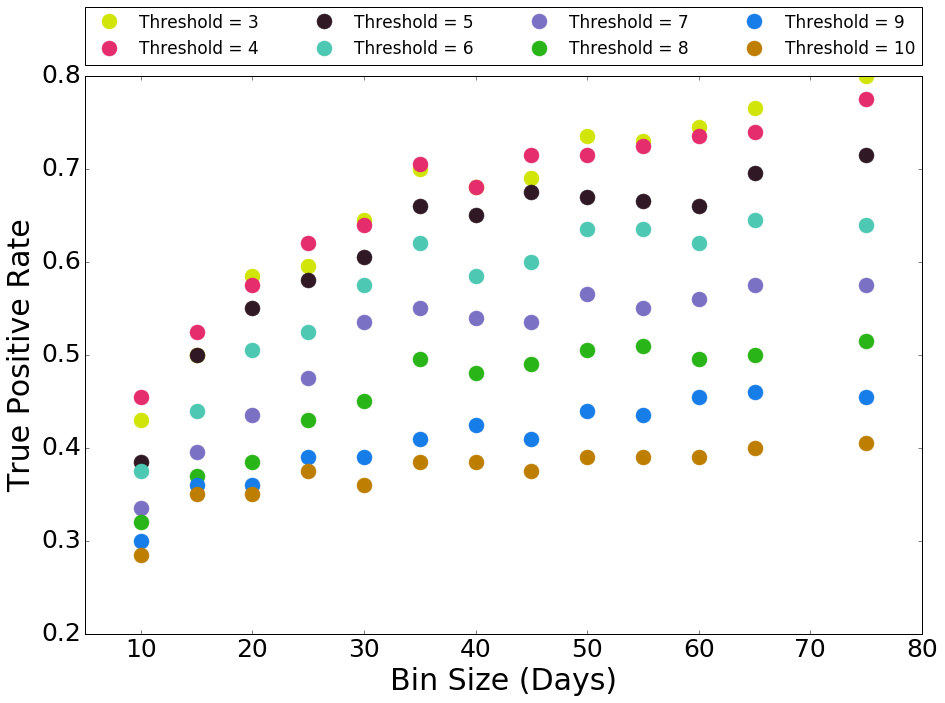

In [54]:
from matplotlib.lines import Line2D


random.seed(150)
legend_elements = []

for t in thre:

    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    plt.plot(b_size, result_perc['threshold_TPR ='+str(t)],'.',label='Threshold = '+str(t), markersize=30,
            color=color)
#     legend_elements.append(Line2D([0], [0], lw=8, color = color , label = 'Threshold = '+str(t)))

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),numpoints=1, loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.,prop={'size': 17})


plt.xlim(5,80)
plt.xlabel('Bin Size (Days)',size=30)
plt.ylabel('True Positive Rate',size=30)
plt.tick_params(axis='y',labelsize=25)
plt.tick_params(axis='x',labelsize=25)
fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
fig.savefig('test_result/Detect_peaks/True_Pos_Rate.png')

In [52]:
# random.seed(100)
# legend_elements = []



# for t in thre:

#     color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
#     plt.plot(b_size, result_perc['threshold_true_neg ='+str(t)],'.',label='Threshold = '+str(t), markersize=30,
#             color=color)
#     legend_elements.append(Line2D([0], [0], lw=8, color = color , label = 'Threshold = '+str(t)))


# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),handles=legend_elements, loc='lower left',
#            ncol=4, mode="expand", borderaxespad=0. ,prop={'size': 17})
# plt.xlim(5,80)
# #plt.ylim(0.6,1.1)

# plt.xlabel('Bin Size (Days)',size=30)
# plt.ylabel('True Negative Rate',size=30)
# plt.tick_params(axis='y',labelsize=25)
# plt.tick_params(axis='x',labelsize=25)
# fig = plt.gcf()
# fig.set_size_inches(15.0,10.0)
# fig.savefig('True_Neg_Rate.png')

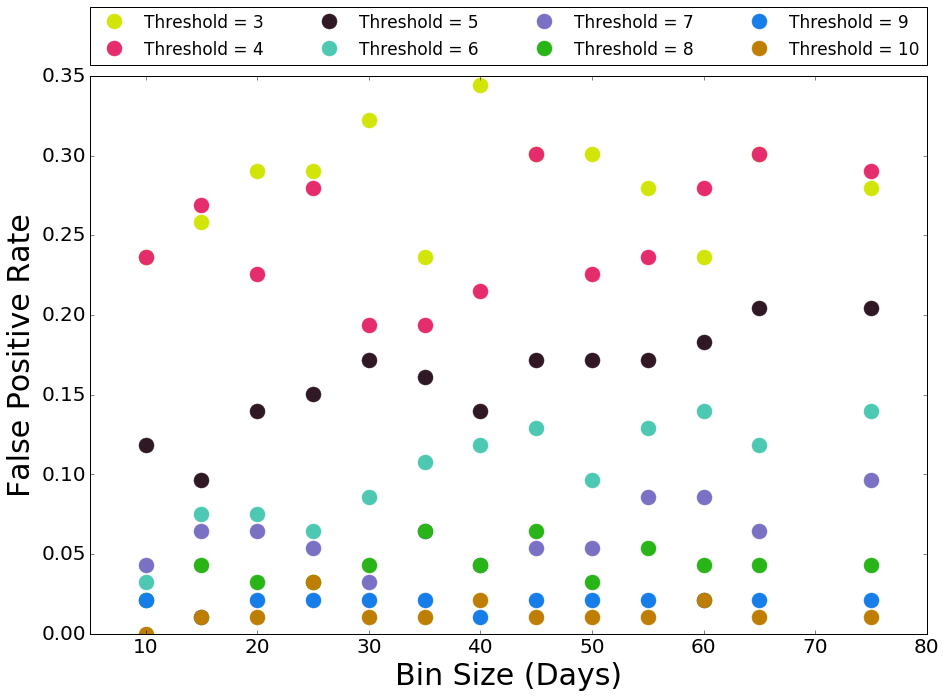

In [58]:
random.seed(150)



for t in thre:

    plt.plot(b_size, result_perc['threshold_FPR ='+str(t)],'.',label='Threshold = '+str(t), markersize=30,
            color="#{:06x}".format(random.randint(0, 0xFFFFFF)))


plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), numpoints=1,loc='lower left',
           ncol=4, mode="expand", borderaxespad=0. ,prop={'size': 17})
plt.xlim(5,80)
#plt.ylim(0.6,1.1)

plt.xlabel('Bin Size (Days)',size=30)
plt.ylabel('False Positive Rate',size=30)
plt.tick_params(axis='y',labelsize=20)
plt.tick_params(axis='x',labelsize=20)
fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
fig.savefig('test_result/Detect_peaks/False_Pos_Rate.png')

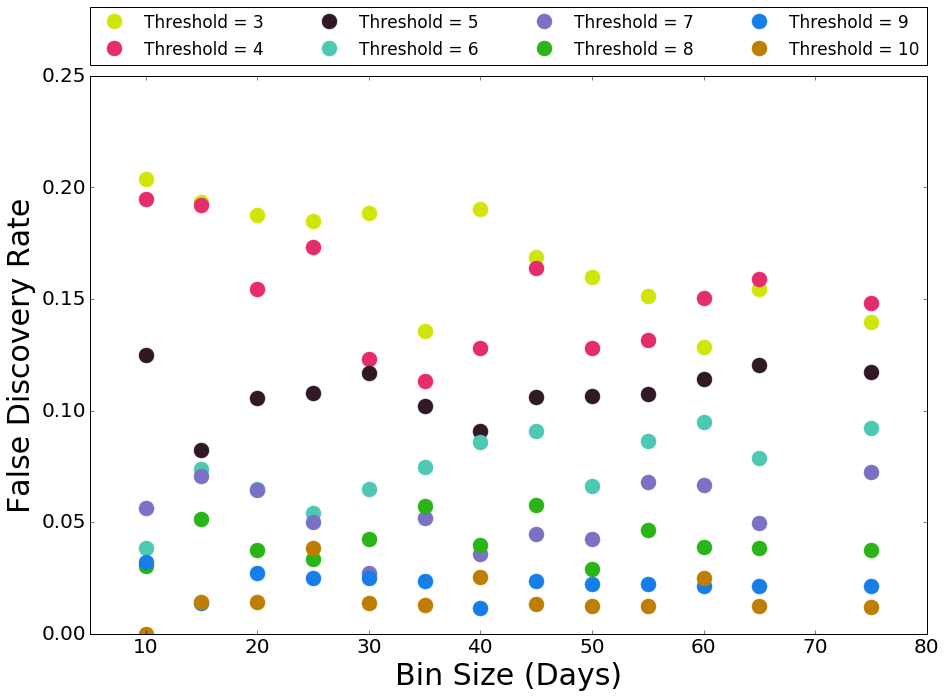

In [59]:
random.seed(150)



for t in thre:

    plt.plot(b_size, result_perc['threshold_FDR ='+str(t)],'.',label='Threshold = '+str(t), markersize=30,
            color="#{:06x}".format(random.randint(0, 0xFFFFFF)))


plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),numpoints=1, loc='lower left',
           ncol=4, mode="expand", borderaxespad=0. ,prop={'size': 17})
plt.xlim(5,80)
#plt.ylim(0.6,1.1)

plt.xlabel('Bin Size (Days)',size=30)
plt.ylabel('False Discovery Rate',size=30)
plt.tick_params(axis='y',labelsize=20)
plt.tick_params(axis='x',labelsize=20)
fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
fig.savefig('test_result/Detect_peaks/False_Discovery_Rate.png')

In [30]:
# random.seed(100)
# legend_elements = []




# for t in thre:
    
#     color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
#     plt.plot(b_size, result_perc['threshold_false_neg ='+str(t)],'.',label='Threshold = '+str(t), markersize=30,
#             color=color)
#     legend_elements.append(Line2D([0], [0], lw=8, color = color , label = 'Threshold = '+str(t)))



# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),handles=legend_elements, loc='lower left',
#            ncol=4, mode="expand", borderaxespad=0. ,prop={'size': 17})
# plt.xlim(5,80)
# #plt.ylim(0.6,1.1)

# plt.xlabel('Bin Size (Days)',size=30)
# plt.ylabel('False Negative Rate',size=30)
# plt.tick_params(axis='y',labelsize=25)
# plt.tick_params(axis='x',labelsize=25)
# fig = plt.gcf()
# fig.set_size_inches(15.0,10.0)
# fig.savefig('False_Neg_Rate.png')

In [34]:
# Define a function that counts the number of outliers of all lightcurves for arbitrary bin sizes and thresholds
# The outputs are two percentages:
# true_perc = (Number of microlensing lightcurves estimated correctly)/(Number of true microlensing lightcurves)
# false_perc = (Number of non-microlensing lightcurves estimated correctly)/(Number of true non-microlensing lightcurves)


def check_thresh_binsize2 (direc, type_true, bin_size, threshold):
    
    
    res = {'name':[], 'outliers':[], 'max_outliers':[], 'n_outliers':[]}

    for f in direc:
        if f.endswith('.txt') and f.split('_')[2].startswith('W'):

            t,m,e = np.loadtxt(temp+str(f),unpack=True)

            df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': e})
            #print np.std(m)
            tempdata = count_peaks(df['t'],df['magnitude'],bin_size=bin_size, threshold=threshold)

            res['name'].append(f)
            res['outliers'].append(tempdata)
            res['max_outliers'].append(np.max(tempdata))
            res['n_outliers'].append(len(np.where(np.asarray(tempdata)>0)[0]))
            
    type_ = []

    for i in range(len(res['n_outliers'])):

        if res['n_outliers'][i] == 1:
            type_.append(1)
        elif res['n_outliers'][i] == 0:
            type_.append(0)
        else:
            type_.append(2)
            
    
    result = pd.DataFrame({'true': type_true, 'estim': type_})
    
    true_pos = len(result[result['true'] == 1][result['estim'][result['true'] == 1]==1]) / float(len(result['estim'][result['true'] == 1]))
    true_neg_0 = len(result[result['true'] == 0][result['estim'][result['true'] == 0]==0]) / float(len(result['estim'][result['true'] == 0]))
    true_neg_2 = len(result[result['true'] == 0][result['estim'][result['true'] == 0]==0]) / float(len(result['estim'][result['true'] == 0]))
    false_neg = len(result[result['true'] == 1][result['estim'][result['true'] == 1]==0]) / float(len(result['estim'][result['true'] == 1]))
    false_pos = len(result[result['true'] == 0][result['estim'][result['true'] == 0]==1]) / float(len(result['estim'][result['true'] == 0]))
    return true_pos, true_neg, false_pos, false_neg



In [35]:
# Count peaks of all lightcurves for a range of thresholds and bin sizes to determine which combination works
# more efficiently and gives higher percentages

thre = np.asarray([3,4,5,6,7,8,9,10])
b_size = np.asarray([10,15,20,25,30,35,40,45,50,55,60,65,75])

result_perc = {}

for t in tqdm(thre):
    bb = [[],[],[],[]]
    for b in b_size:
        
        #print b,t
        
        true_pos, true_neg, false_pos, false_neg = check_thresh_binsize2 (direc, typ2, b, t)
        
        bb[0].append(true_pos)
        bb[1].append(true_neg)
        bb[2].append(false_pos)
        bb[3].append(false_neg)
        
    result_perc['threshold_true_pos ='+str(t)]= np.asarray(bb[0])
    result_perc['threshold_true_neg ='+str(t)]= np.asarray(bb[1])
    result_perc['threshold_false_pos ='+str(t)]= np.asarray(bb[2])
    result_perc['threshold_false_neg ='+str(t)]= np.asarray(bb[3])

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 